In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from glob import glob
# Built-in imports
import os, datetime, pathlib, random 
from glob import glob
import math
from math import ceil, floor

# Basic imports
import numpy as np
import pandas as pd   

# Ploting libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)

import PIL
from PIL import Image
import skimage
from skimage import color, io
from skimage import transform

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras import applications, optimizers, models, losses, layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D

tf.compat.v1.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [3]:
# Show image
def show_image(image, title='Image',cmap_type='gray'):
  plt.imshow(image, cmap=cmap_type)
  plt.title(title)
  plt.axis('off')
  plt.show()

In [4]:
# Path to project
path_project_dir = pathlib.Path('/content/drive/MyDrive/DeepLearningInVisionHSLU/DLV03_Project/')
# Path to data 
path_to_data = path_project_dir.joinpath('data','train_test') / 'Arabic Handwritten Characters Dataset CSV' # because of github, this folder has been moved to the parent directory. 
# Path to images
path_to_images = path_project_dir.joinpath('data','images')
# arabic labels 
arabic_labels = {1: 'Alif', 2: 'Ayeen', 3: 'Baa', 4: 'Daal', 5: 'Faa', 6: 'Ghaeen', 7: 'Haa', 8: 'Jeem', 9: 'Kaaf', 10: 'Khaa', 11: 'Laam', 
                 12: 'Meem', 13: 'Nuun', 14: 'Qouf', 15: 'Raa', 16: 'Saa', 17: 'Seen', 18: 'Sheen', 19: "Su'ad", 20: 'Taa', 21: 'Tuaa', 
                 22: 'Waoo', 23: 'Yaa', 24: 'Zaal', 25: 'Zazza', 26: "Zu'ad", 27: 'Zua', 28: 'huu'}
# approximation - alphabet to arabic
alphabet_to_arabic = {'a': 'Alif','b': 'Baa','d':'Daal','f': 'Faa','r': 'Ghaeen','h': 'Haa','j': 'Jeem','k': 'Kaaf','l': 'Laam',
                      'm': 'Meem','n': 'Nuun','q': 'Qouf','r': 'Raa','s': 'Saa','t': 'Taa','u': 'Waoo','i': 'Yaa','z': 'Zaal'}
# approximation - arabib to alphabet
arabic_to_alphabet = {v:k for k,v in alphabet_to_arabic.items()}

In [5]:
# Images
train_imgs = pd.read_csv(path_to_data.joinpath('csvTrainImages 13440x1024.csv'),header = None).values.astype('float32').reshape(-1,32,32,1) 
test_imgs = pd.read_csv(path_to_data.joinpath('csvTestImages 3360x1024.csv'),header = None).values.astype('float32').reshape(-1,32,32,1) 
# Labels
train_labels = pd.read_csv(path_to_data.joinpath('csvTrainLabel 13440x1.csv'),header = None)
test_labels = pd.read_csv(path_to_data.joinpath('csvTestLabel 3360x1.csv'),header = None)

df_train = train_labels.rename(columns={0:'label'})
df_test = test_labels.rename(columns={0:'label'})

df_test

,label
0,1
1,1
2,2
3,2
4,3
...,...
3355,26
3356,27
3357,27
3358,28


In [6]:
def get_img(img_num, array = test_imgs):
  return array[img_num][:,:,0]

df_train = (df_train
            .assign(name = lambda x: x.label.apply(arabic_labels.get))
            .assign(equivalent = lambda x: x.name.apply(arabic_to_alphabet.get))
            .assign(img_array = lambda x: x.label.apply(get_img))
)
df_test = (df_test
            .assign(name = lambda x: x.label.apply(arabic_labels.get))
            .assign(equivalent = lambda x: x.name.apply(arabic_to_alphabet.get))
            .assign(img_array = lambda x: x.label.apply(get_img))
)

df_test.head()

,label,name,equivalent,img_array
0,1,Alif,a,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,Alif,a,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2,Ayeen,None,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,2,Ayeen,None,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,3,Baa,b,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


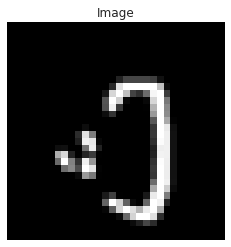

In [18]:
number = 7
show_image(
df_test[df_test.label == number].sample(1).img_array.values[0]
)

Image array input "Haa" equivalent to "h"


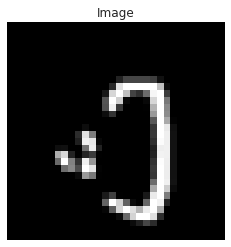

In [19]:
# Create a sample img
test_sample = df_test[df_test.label == 7].sample(1)
print(f'Image array input "{test_sample.name.values[0]}" equivalent to "{test_sample.equivalent.values[0]}"')
test_img = test_sample.img_array.values[0]

# Show this image
show_image(test_img)

In [29]:
# reload model 4 - best model
predictor = tf.keras.models.load_model(
    str(path_project_dir.joinpath('models','model_4.h5'))
    )

# Show prediction
to_predict = test_img.reshape(-1,32,32,1)
predictor.predict(to_predict)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [10]:
# get style sheets
style_and_content = glob(str(path_to_images)+'/*', recursive = True)

# get styles/content
path_styles = {item.split('/')[-2]:item for item in glob(style_and_content[0] + '/*/*')}
path_content = {item.split('/')[-2]:item for item in glob(style_and_content[1] + '/*/*')}

print(path_styles.keys())
print(path_content.keys())

dict_keys(['andreas', 'patrizia', 'aaron', 'simon', 'bernardo', 'mirko'])
dict_keys(['d', 'm', 'v', 'p'])


In [11]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)